# 第6章 Stable Diffusion

## 6.1 基本概念

- 隐式扩散：使用VAE（Variational Auto-Encoder）将图片映射到一个较小的隐式表征，再将其映射到原始图片，通过在隐式表征上进行扩散，可以使用更少的内存，减少UNet层数并加速图片的生成。还可以将结果输入VAE解码器中，得到高分辨率图像。

![latent-diffusion-diagram.png](./images/ch06-01-latent-diffusion-diagram.png)

- 以文本为生成条件：在推理阶段，输入期望图像的文本描述，将纯噪声数据作为起点，然后模型对噪声输入进行“去噪”，生成能匹配文本描述的图像。
    1. CLIP的文本编码器将文本描述转换为特征向量，该特征向量用于与图像特征向量进行相似度比较。
    2. 输入的文本提示语进行分词，然后被输入CLIP的文本编码器。
    3. 使用交叉注意力机制，交叉注意力贯穿整个UNet结构，UNet中的每个空间位置都可以“注意”到文字条件中不同的token，从文本提示语中获取不同位置的相互关联信息。

![sd-unet-color](./images/ch06-02-sd-unet-color.png)

- 无分类引导：主要解决可能得到与文字描述根本不相关的图片，具体方法如下：
    1. 训练阶段，强制模型学习在无文字信息的情况下对图片“去噪”（无条件生成）。
    2. 推理阶段，进行有文字条件预测、无文字条件预测，利用两者差异建立最终结合版的预测。

- 使用DreamBooth进行微调：DreamBooth是一种个性化训练一个文本到图像模型的方法，只需要提供一个主题的3~5张图像，就能教会模型有关这个主题的各种概念，从而在不同的场景和视图中生成这个主题的相关图像。

## 6.2 环境准备

In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )       

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

device =  "cuda" if torch.cuda.is_available() else "cpu"

## 6.3 从文本生成图像

In [2]:
# 加载管线
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

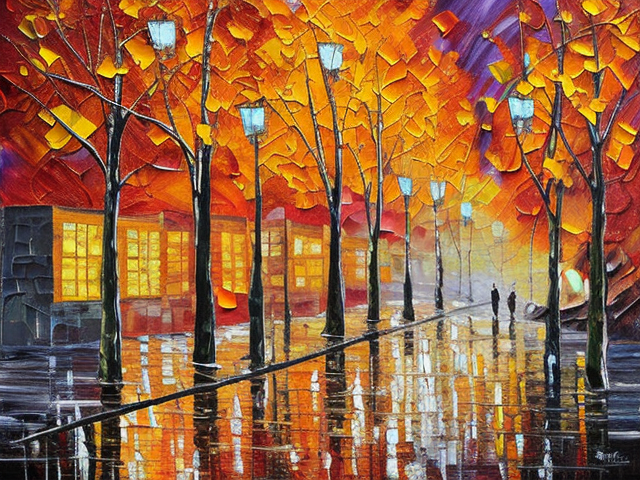

In [5]:
# 给生成器设置一个随机种子
generator = torch.Generator(device=device).manual_seed(42)

pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", 
    negative_prompt="Oversaturated, blurry, low quality", 
    height=480, width=640,     # 图片大小
    guidance_scale=8,          # 提示文字的影响程度
    num_inference_steps=35,    # 推理步数
    generator=generator        # 设置随机种子生成器
)

pipe_output.images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

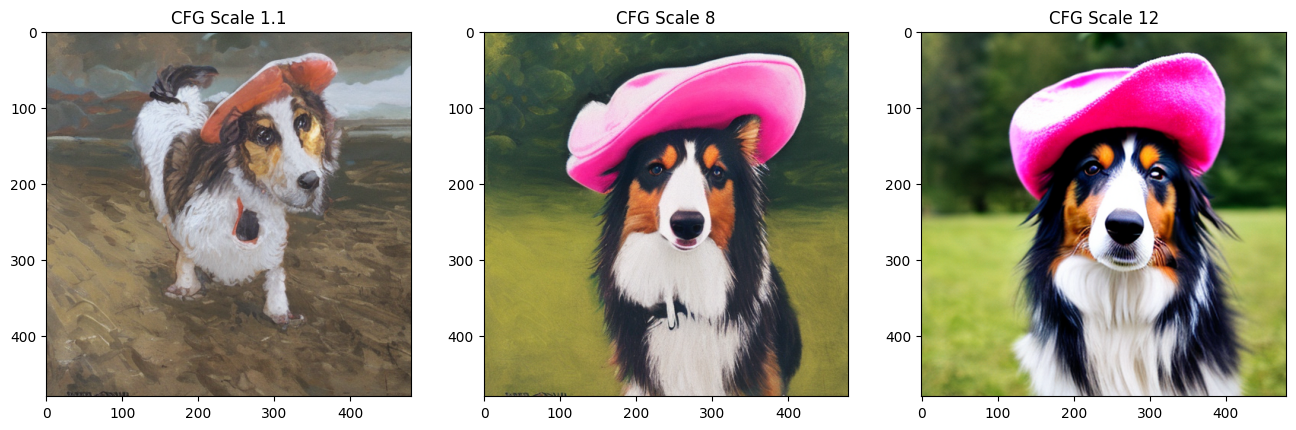

In [6]:
# 对比不同的guidance_scale效果（该参数决定了无分类器引导的影响强度）
cfg_scales = [1.1, 8, 12] 
prompt = "A collie with a pink hat" 
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(prompt, height=480, width=480,
        guidance_scale=cfg_scales[i], num_inference_steps=35,
        generator=torch.Generator(device=device).manual_seed(42)).images[0]
    ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

## 6.4 Stable Diffusion Pipeline

- 可变分自编码器：对输入图像进行VAE编码器，然后生成隐编码，在VAE解码器中进行解码，得到解码后的图像。

In [7]:
# 创建区间为(-1, 1)的伪数据
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# 编码到隐空间
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# 解码
with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


- 分词器和文本编码器：将输入的字符串（文本提示语）转换成数值表示形式。

In [10]:
# 手动对提示文字进行分词和编码
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# 将分词结果输入CLIP
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [21]:
# 进行编码
text_embeddings = pipe.encode_prompt(
    prompt="A painting of a flooble", 
    device=device, 
    num_images_per_prompt=1, 
    do_classifier_free_guidance=False, 
    negative_prompt='')
print("Text embeddings shape:", text_embeddings[0].shape)

Text embeddings shape: torch.Size([1, 77, 1024])


- UNet：主要作用是接收“带噪”的输入并预测噪声，实现“去噪”。

In [22]:
# 创建伪输入
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# 模型预测
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape)

UNet output shape: torch.Size([1, 4, 64, 64])


- 调度器：保存关于添加噪声的信息，并管理如何基于模型的预测更新“带噪”样本。默认调度器是PNDMScheduler。

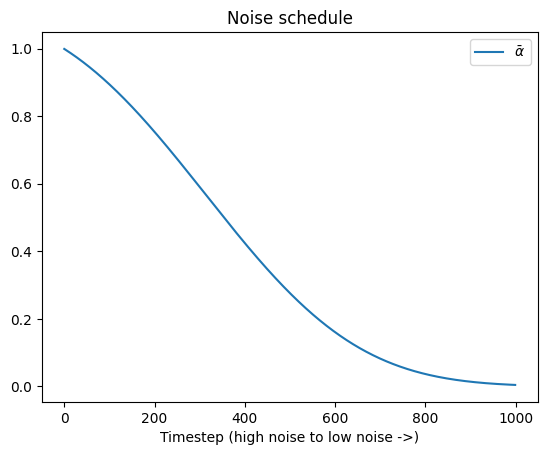

In [24]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)')
plt.title('Noise schedule')
plt.legend();

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.21.4",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



  0%|          | 0/50 [00:00<?, ?it/s]

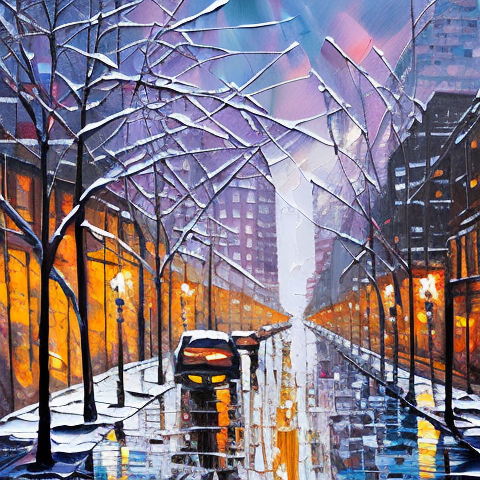

In [9]:
from diffusers import LMSDiscreteScheduler

# 替换调度器
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

print('Scheduler config:', pipe.scheduler)

# 使用新的调度器生成图像
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

- DIY采样循环：主要整合整个管线的功能。

E:\LearningDisk\Learning_Projects\MyPythonProjects\my-team-learning\venv\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:237: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
E:\LearningDisk\Learning_Projects\MyPythonProjects\my-team-learning\venv\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:430: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


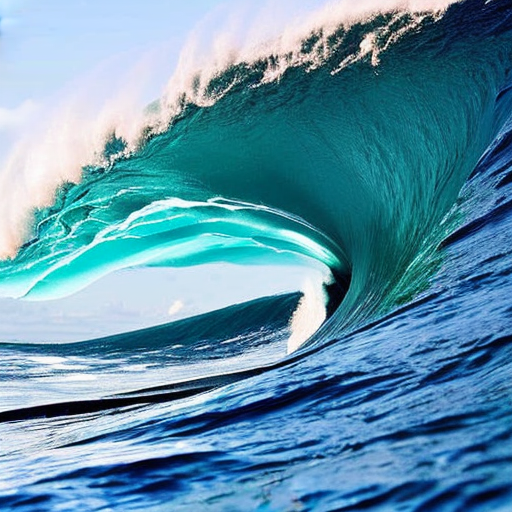

In [14]:
guidance_scale = 8 
num_inference_steps=30 
prompt = "Beautiful picture of a wave breaking" 
negative_prompt = "zoomed in, blurry, oversaturated, warped" 

# 对提示文字进行编码
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# 创建随机噪声作为起点
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# 设置调度器
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# 循环采样
for i, t in enumerate(pipe.scheduler.timesteps):
    
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, text_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# 将隐变量映射到图片
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

pipe.numpy_to_pil(image)[0]

## 6.5 其他管线

- Img2Img：首先会对一张已有的图片进行编码，得到隐变量后添加随机噪声。

In [2]:
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

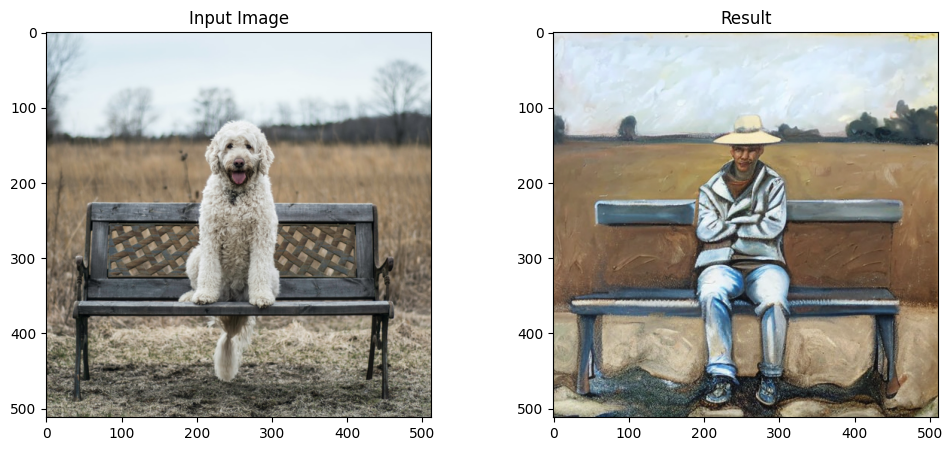

In [3]:
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image = init_image,
    strength = 0.6, # 强度：0表示完全不起作用，1表示作用强度最大
).images[0]


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

- Inpainting：接收一张掩模图片作为额外条件输入，该掩模图片与输入图片的尺寸一致，白色区域表示要替换的部分，黑色区域表示要保留的部分。

In [9]:
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
pipe = pipe.to(device)

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

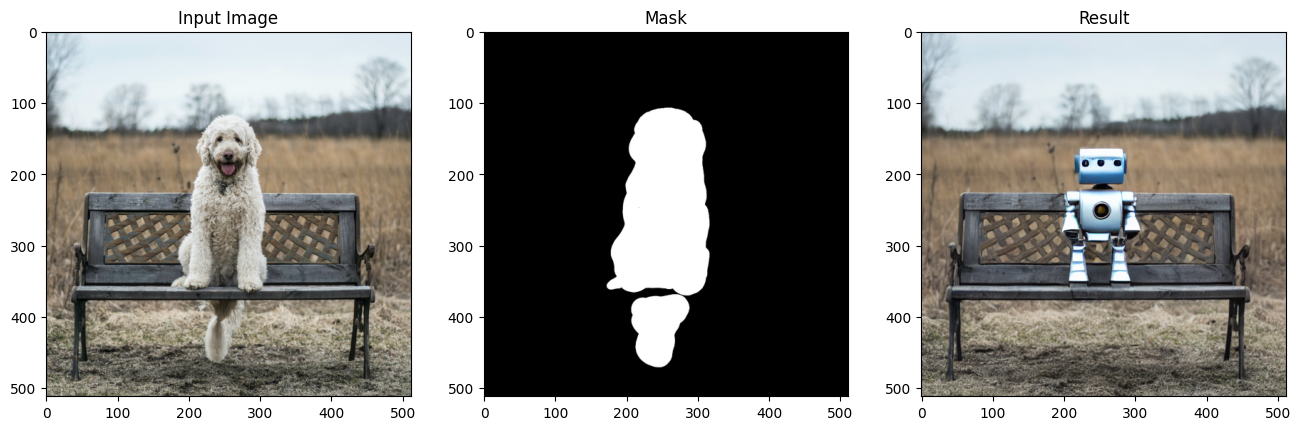

In [5]:
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

- Depth2Image：采用深度预测模型来预测一个深度图，该深度图被输入为跳过的UNet以生成图片。

In [7]:
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

depth_estimator\model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

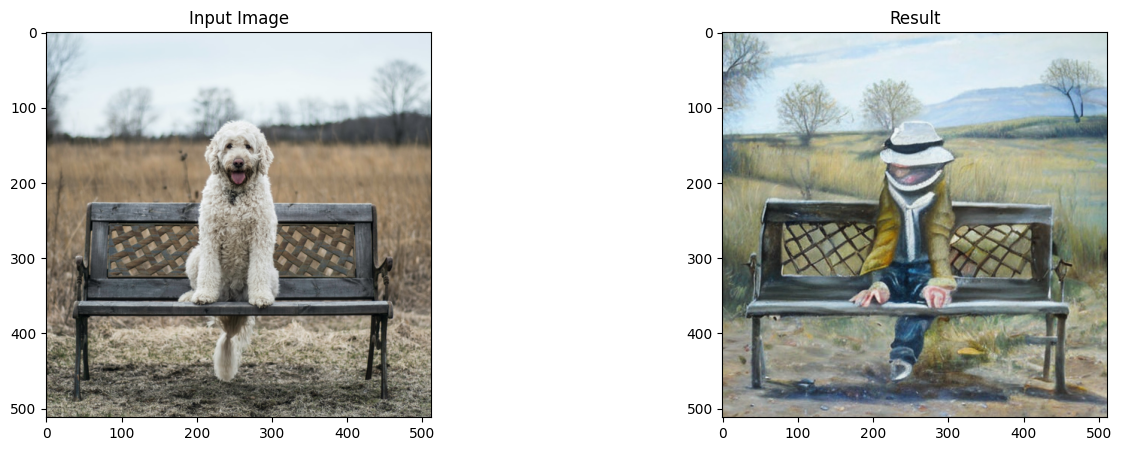

In [8]:
prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result');

对比Img2Img生成的图片，Depth2Img生成的图片有丰富的色彩变化，整体结构更忠于原图。